<a href="https://colab.research.google.com/github/torkralle/colab-overtone/blob/master/vocoder_time_variant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下準備


## ライブラリのインポート

In [1]:
%matplotlib inline
import sys
sys.path.append('/content/drive/MyDrive/Laboratory/Colab/overtone/modules')
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import display, Audio
import scipy.io.wavfile
import copy
import filter
import wave_file as wav
import window_function as wf
import average_function as af
import furie_function as ff
import filter
import helper

## 音声のインポート

In [2]:
# vocal_fs: rateボーカル音
vocal_path = "/content/drive/MyDrive/Laboratory/Colab/overtone/sounds/plain.wav"
vocal_fs, vocal = wav.wave_read_16bit_mono(vocal_path)

# fs: rate, vocal: data ホーミー音 高音
overtone_path = "/content/drive/MyDrive/Laboratory/Colab/overtone/sounds/overtone.wav"
overtone_fs, overtone = wav.wave_read_16bit_mono(overtone_path)

## データの下準備

### 必要な定数の定義

In [3]:
# サンプリング周波数
fs = 44100

# 2**16 65536
bits = 16
normalize_value = 2 ** (bits - 1)

# バッチ数
N = 4096

# 正規化
vocal = vocal.astype(np.float) / normalize_value
overtone = overtone.astype(np.float) / normalize_value

# vocalとovertoneの配列の長さを取得
length_of_vocal = len(vocal)
length_of_overtone = len(overtone)

# N以外の場所を取って、フレーム数を調べる
# オーバーラップアドで半分重なってるためフレーム数は
number_of_frame = int(np.round((length_of_vocal - N/2) / (N/2)))

# 8個取ってきて平均を取る 
# バンド幅が8であるから2*8で割る(フーリエ変換の折り返し分の2)
band_width = 8
number_of_band = int(np.round(N / 2 / band_width))

# 出力結果を格納する配列を作成
master_volume = 0.5
new_sound_name = "new3.wav"
new_sound = np.zeros(length_of_vocal)

### データの確認

In [4]:
print(f"ボーカルのサンプリング周波数 {vocal_fs}")
print(f"ホーミーのサンプリング周波数 {overtone_fs}\n")

print(f"ボーカルの配列長 {length_of_vocal}")
print(f"ホーミーの配列長 {length_of_overtone} \n")

print(f"総フレーム数 {number_of_frame}")
print(f"総バンド数 {number_of_band}")

ボーカルのサンプリング周波数 48000
ホーミーのサンプリング周波数 48000

ボーカルの配列長 141248
ホーミーの配列長 133056 

総フレーム数 68
総バンド数 256


### データの可視化


141248
133056


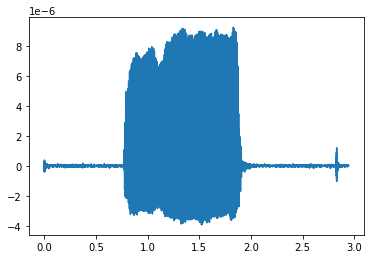

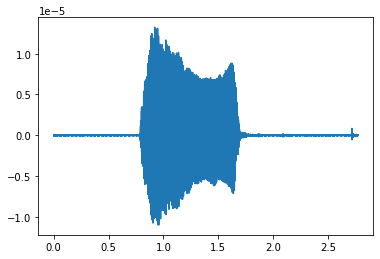

In [5]:
# 横軸（時間）の配列を作成　
# np.arange(初項, 等差数列の終点, 等差)
vocal_t = np.arange(0, vocal.shape[0]/vocal_fs, 1/vocal_fs)  
plt.figure()
plt.plot(vocal_t, vocal)
plt.savefig('vocal.png')
print(length_of_vocal)

overtone_t = np.arange(0, overtone.shape[0]/overtone_fs, 1/overtone_fs)  
plt.figure()
plt.plot(overtone_t, overtone)
plt.savefig('overtone.png')
print(length_of_overtone)

# 本処理

In [6]:
# ホーミーにハイパスフィルターを掛ける
overtone = filter.highpass_filter(overtone)

for frame in range(number_of_frame):
    # フーリエ変換のために、ハニング窓を乗算する
    # ボーカル
    v, is_limit = wf.multiply_hanning_window(vocal, frame, length_of_vocal)
    if(is_limit):
        break
    V = np.fft.fft(v)

    # ホーミー
    h, is_limit = wf.multiply_hanning_window(overtone, frame, length_of_overtone)
    if(is_limit):
      break
    H = np.fft.fft(h)
    H = ff.convert_into_absolute_value(H, N)
    H = helper.pool_average(band_width, number_of_band, H)
    H = ff.symmetric_copy(H, N)

    # ボーカルV ホーミーHとの畳込み
    Y = ff.convolution(V, H, N)
    y = np.real(np.fft.ifft(Y))

		# バッチ処理なので、順にyをnew_soundに足していく
    offset =  int(np.round(N / 2 * (frame - 1)))
    for n in range(N):
        new_sound[offset+n] = new_sound[offset+n] + y[n]

this is limit index,  133056


In [7]:
new_sound = helper.normalize_sound(new_sound, master_volume)
wav.wave_write_16bit_mono(vocal_fs, new_sound, new_sound_name)
fs, new_sound_data = wav.wave_read_16bit_mono(new_sound_name)
Audio(new_sound_name)

In [8]:
vocal_fs, vocal = wav.wave_read_16bit_mono(vocal_path)
overtone_fs, overtone = wav.wave_read_16bit_mono(overtone_path)

distance_from_plain, path_from_vocal = helper.get_euclidean_dtw(overtone, vocal)
distance_from_new, path_from_new = helper.get_euclidean_dtw(overtone, new_sound_data)

print("元の音声とホーミーの距離: ", distance_from_plain)
print("作った音声とホーミーの距離: ", distance_from_new)

元の音声とホーミーの距離:  2923.0073542609925
作った音声とホーミーの距離:  2444.5031251616783
